# Simple example for B-mode imaging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg
import straight_ray_tomo
from straight_ray_tomo import straight_ray_tracer
import xarray as xr
from scipy.signal import hilbert
import h5py

plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({"font.size": 20})
plt.rcParams["xtick.major.pad"] = "20"
plt.rcParams["ytick.major.pad"] = "20"

### Define some functions

In [3]:
def plot_Bmode_image(reflectivity, grid):
    bmode = 10 * np.log10(reflectivity) - np.max(10 * np.log10(reflectivity)) + 60
    bmode[bmode > 60] = 60
    bmode[bmode < 0] = 0
    plt.figure(figsize=(15, 8))
    plt.imshow(
        np.reshape(bmode, [grid.x.shape[0], grid.y.shape[0]]),
        extent=[
            grid.x[0],
            grid.x[0] + grid.x.shape[0] * np.array(grid.spacing),
            grid.y[0],
            grid.y[0] + grid.y.shape[0] * np.array(grid.spacing),
        ],
        cmap="gray",
        origin="lower",
    )
    plt.title("B-mode")
    plt.xlabel("x[mm]")
    plt.ylabel("y[mm]")
    plt.colorbar(label="reflectivity")

In [4]:
def plot_Bmode_image_example(
    reflectivity, grid, isrc, irec, srccoo, reccoo, activeChannels
):
    # Some scaling commonly used in medical delay and sum beamformers.
    bmode = 10 * np.log10(reflectivity) - np.max(10 * np.log10(reflectivity)) + 60
    bmode[bmode > 60] = 60
    bmode[bmode < 0] = 0

    plt.figure(figsize=(15, 8))
    plt.imshow(
        np.reshape(bmode, [grid.x.shape[0], grid.y.shape[0]]).T,
        extent=[
            grid.x[0],
            grid.x[0] + grid.x.shape[0] * np.array(grid.spacing),
            grid.y[0],
            grid.y[0] + grid.y.shape[0] * np.array(grid.spacing),
        ],
        cmap="gray",
        origin="lower",
    )
    plt.plot(srccoo[:, 0], srccoo[:, 1], ".")
    plt.plot(srccoo[isrc, 0], srccoo[isrc, 1], "r*", markersize=10)
    if type(activeChannels) == int:
        plt.plot(
            reccoo[isrc, activeChannels, 0],
            reccoo[isrc, activeChannels, 1],
            "yv",
            markersize=10,
        )
    else:
        plt.plot(
            reccoo[isrc, activeChannels[:, isrc].astype(int), 0],
            reccoo[isrc, activeChannels[:, isrc].astype(int), 1],
            "yv",
            markersize=10,
        )
    plt.title("B-mode")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.colorbar(label="reflectivity")

In [5]:
def get_Bmode_image(
    dataMatrix,
    srccoo,
    reccoo,
    activeChannels,
    m_prior,
    grid,
    npoints,
    origin,
    sampling_rate,
    acquisition_delay=None,
):
    """
    B-mode algorithm for reflection ultrasound data

    :param dataMatrix (ndarray):          signal Matrix with shape (numTimeSamples x numEmittingElements x numReceivingElements).
    :param sampling_rate (float):         sampling frequency in Hz.
    :param srccoo (ndarray):              X position of source elements = axis 0, Y position of source elements = axis 1.
    :param reccoo (ndarray):              X position of receiver elements = axis 0, Y position of receiver elements = axis 1.
    :param activeChannels (ndarray):      Active channels in reception (numTxEvents x numRxChannels).
    :m_prior (ndarray):                   Prior in model space. 1D array with size (numPixel^2, 1).
    :grid (object):                       Grid for rectilinear meshes in 2D and 3D.
    :npoints (float):                     number of point in grid.
    :origin (float):                      origin of the grid.
    :acquisition_delay (float):           delay given as part of the specific acquisition system (default=None).

    :return:                              reflectivity (ndarray).
    """

    n_src = srccoo.shape[0]
    n_rec = reccoo.shape[1]
    nsamples = dataMatrix.shape[0]
    reflectivity = np.zeros(m_prior.shape)
    spacing = np.array(grid.spacing)
    dim = npoints.shape[0]

    coords = np.zeros([np.prod(npoints), dim])

    x = np.linspace(
        origin[0], origin[0] + spacing * npoints[0], num=npoints[0], endpoint=False
    )
    y = np.linspace(
        origin[1], origin[1] + spacing * npoints[1], num=npoints[1], endpoint=False
    )

    xv, yv = np.meshgrid(x, y, indexing="ij")

    coords[:, 0] = xv.flatten()
    coords[:, 1] = yv.flatten()

    for i_src in tqdm.trange(n_src):

        source_dist = np.linalg.norm(coords - srccoo[i_src, :], axis=1)

        reflectivity_re = np.zeros(m_prior.shape)
        reflectivity_im = np.zeros(m_prior.shape)

        for i_activeReflElm in range(activeChannels.shape[0]):
            idx_rec = activeChannels[:, i_src][i_activeReflElm].astype(int)
            data_analytical = hilbert(dataMatrix[:, i_src, idx_rec])

            activeReflElmPos = reccoo[i_src, activeChannels[:, i_src].astype(int), :]
            rec_dist = np.linalg.norm(
                coords - activeReflElmPos[i_activeReflElm, :], axis=1
            )

            if acquisition_delay == None:
                time_idx = np.round(
                    ((source_dist + rec_dist) * m_prior) * np.array([[sampling_rate]])
                ).astype(int)[0]
            else:
                time_idx = np.round(
                    (
                        (source_dist + rec_dist) * m_prior
                        + np.array([[acquisition_delay]])
                    )
                    * np.array([[sampling_rate]])
                ).astype(int)[0]

            mask = time_idx < nsamples

            reflectivity_re[mask] = (
                reflectivity_re[mask] + data_analytical.real[time_idx[mask]]
            )
            reflectivity_im[mask] = (
                reflectivity_im[mask] + data_analytical.imag[time_idx[mask]]
            )

        reflectivity += reflectivity_re ** 2 + reflectivity_im ** 2

    return reflectivity

### Intro

In this little tutorial, we will take a look at one of the most important imaging methods for medical ultrasound: B-mode imaging or pulse-echo imaging, which in seismological terms translates to reflection imaging. Consequently, we will be looking at the part of the data that contains - mostly or exclusively - waveforms that have been reflected at material discontinuities. The data that we are going to use is part of the [usct data challenge 2019](https://usct.gitlab.io/datachallenge2019/data/) and consists of a 2D numerical breast phantom mimicking a cross-sectional slice through a breast. Our goal will be to image the interior structure, which contains ellipsoids of different sizes, from a set of scans obtained with a circular transducer array, where every transducer acts as an ultrasonic source and receiver. This array acquires reflection and transmission data at once. Since we are interested in only the reflection part of the data, we need to eliminate the first arrivals, because those will map artefacts in the reconstruction.

### Data from usct data challenge 2019

First we load the data.

In [6]:
# Load data from usct data challenge 2019.
phantom_data = np.zeros([16025, 249, 248])
reccoo = np.zeros([249, 248, 2])
srccoo = np.zeros([249, 2])
with h5py.File("phantom_simple.h5") as hf:
    sampling_rate = np.array(
        hf["scans"]["scan_0000"]["receiver"]["waveforms"].attrs[
            "sampling_rate_in_hertz"
        ]
    )
    start_time = np.array(
        hf["scans"]["scan_0000"]["receiver"]["waveforms"].attrs["start_time_in_seconds"]
    )
    for i_scan, scan in enumerate(hf["scans"]):
        srccoo[i_scan, :] = np.array(hf["scans"][scan]["emitter"]["location"])
        reccoo[i_scan, :, :] = np.array(hf["scans"][scan]["receiver"]["locations"])
        phantom_data[:, i_scan, :] = np.array(
            hf["scans"][scan]["receiver"]["waveforms"]
        )

We can see that the data consist of 249 sources and for every source 248 receivers are active, meaning all receivers ecxept the one that is acting as a source are collecting the signal. As mentioned above, we need to be careful with the receivers that collect transmission data. We could either apply a top mute to the data that gets rid of the first arrivals, or we just select a set of receivers closest to the source for which we know that the fist arrival opart will be clearly separated from the reflection part in the traces.

In [7]:
numRxChannels = 82  # Number of elements used for reflection data. We will use numRxChannels / 2 receivers to each side of the source.
activeChannels = np.zeros((numRxChannels + 1, 249))
for colInd in range(0, 249):
    activeChannels[:, colInd] = (
        np.linspace(
            colInd - int(numRxChannels / 2),
            colInd + int(numRxChannels / 2),
            numRxChannels + 1,
            dtype=int,
        )
        % 248
    )
activeChannels.shape

(83, 249)

Just because we want to make sure there are no first arrivals left in the reflection data that we are going to use, we set everything before timesample 7400 to zero.

In [8]:
# Mute part of the first arrival by hand.
phantom_data[:7400, :, :] = 0.0

# Let's take a look at a shot gather!
isrc = 40
plt.figure(figsize=[10, 8])
plt.imshow(
    phantom_data[:, isrc, activeChannels[:, isrc].astype(int)],
    cmap="seismic",
    aspect="auto",
    vmin=-0.2,
    vmax=0.2,
)
plt.xlabel("number of receiver")
plt.ylabel("time step")
plt.title("common shot gather")
plt.colorbar()

### Setup grid object

With our goal in mind to obtain a 2D image of the data, we notice that we need a 2D grid with a number of pixels, each pixel representing a small part of our image. We use the source and receiver coordinates as an outer bound to construct a grid of coordinates.

In [9]:
sources, receivers = straight_ray_tomo.get_all_to_all_locations(srccoo, reccoo[0, :, :])
print(sources.shape, receivers.shape)

# Make domain and computational grid.
spacing = 0.0005

min_x = min(np.min(sources[:, 0]), np.min(receivers[:, 0]))
min_y = min(np.min(sources[:, 1]), np.min(receivers[:, 1]))
max_x = max(np.max(sources[:, 0]), np.max(receivers[:, 0]))
max_y = max(np.max(sources[:, 1]), np.max(receivers[:, 1]))

origin = np.array([min_x, min_y])
npoints = np.array(
    [int(np.ceil((max_x - min_x) / spacing)), int(np.ceil((max_y - min_y) / spacing))]
)

g = xr.Dataset(
    coords={
        "x": np.linspace(min_x, max_x, npoints[0], endpoint=True),
        "y": np.linspace(min_y, max_y, npoints[1], endpoint=True),
        "spacing": spacing,
    },
)


print(g)

(61752, 2) (61752, 2)
<xarray.Dataset>
Dimensions:  (x: 396, y: 396)
Coordinates:
  * x        (x) float64 -0.099 -0.0985 -0.098 -0.0975 ... 0.098 0.0985 0.099
  * y        (y) float64 0.051 0.0515 0.052 0.0525 ... 0.2475 0.248 0.2485 0.249
    spacing  float64 0.0005
Data variables:
    *empty*


### Setp the straight-ray tracing matrix

B-mode imaging is a linear imaging technique which assumes that waves travel along rays with infinite frequency. The image is constructed by focussing the receiverd enery into the scatterer locations, which is also known as delay-and-sum principle. Before we analyze what the algorithm exactly does, let's initiate the straight-ray tracing matrix, which connects every source to every receiver.

Matrix shape:             (61752, 156816)
Data points:              61752
Unknowns in model space:  156816
Non-zero entries:         19833213
Ratio of non-zeros:     0.2048 %


(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:title={'center':'spacing = 0.0005'}, xlabel='x [m]', ylabel='y [m]'>)

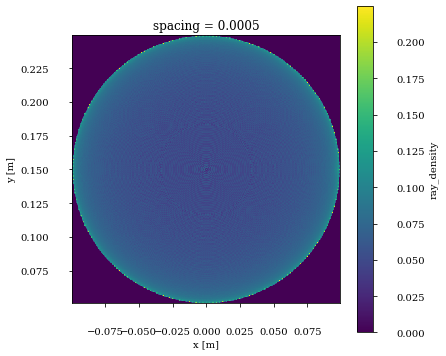

In [10]:
G = straight_ray_tracer.create_forward_operator(sources, receivers, g)
print("Matrix shape:            ", G.shape)
print("Data points:             ", G.shape[0])
print("Unknowns in model space: ", G.shape[1])
print("Non-zero entries:        ", G.count_nonzero())
print(
    "Ratio of non-zeros: {:10.4f} %".format(
        100 * G.count_nonzero() / (G.shape[0] * G.shape[1])
    )
)
straight_ray_tomo.plot_ray_density(G, g)

In order to trace rays from each source to each receiver and estimate the travel time for a ray, we need an initial model, a so called prior model. For B-mode imaging, this is a homogeneous model, which is here parametrized in slowness, the natural parametrization for travel time tomography.

In [11]:
# Prior in model space.

prior = 1500 * np.ones(npoints)
g["soundspeed"] = (["x", "y"], prior)
m_prior = (1 / np.array(g.data_vars["soundspeed"])).ravel()
print(prior.shape, G.shape)

(396, 396) (61752, 156816)


### B-mode algorithm

We are now ready to implement the B-mode algorithm. We are interested in imaging the reflections of the ultrasonic waves that happen at interfaces with impedance contrast in the medium. At an interface, part of the wave energy is transmitted, whilst part of it is reflected with a ratio depending on the strength of the impedance contrast. Hence we can interpret each interface location as the location of a scatterer and more precisely as the location of a first scattering event. Due to Huygen's principle, we can interpret each of these first order scattering events as a secondary source that emit circular wavefronts. Compared to the direct path between the source and the receiver, this secondary event will arrive with a delay at the receiver. The secondary wave will still interfere constructively with the first arrival if the difference is less than half a wavelength $\lambda$. This region of constructive interference is called the first $\textit{Fresnel zone}$ and it has the shape of an ellipse with the distance $d$ between the source and receiver being the longer axis and the width being equal to $\sqrt{\lambda d}$. Thus our goal will be to find all locations in the grid that, when being equal to a first order scattering location yield a travel time that lies within the first Fresnel zone. It is iportant to note that by assuming only first order scattering (and neglecting higher orders), B-mode imaging is a linearization of the wave equation at the optimum.Furthermore, in B-mode imaging, one typically assumes constant tissue velocity to calculate traveltimes.

In the discrete 2D setup for which we constructed a 2D grid or array of pixels, each pixel is now given by a tupel of coordinates. From the knowledge of the source and receiver coordinates, we can now step through the entire grid and check the travel time from each source to each potential scattering location (so all pixels in the grid) and then to a receiver. In the following, we will use a the analytical representation of the signal $s(\mathbf{x}_i^r,t;\mathbf{x}_j^s)$, which consists of the original signal $p(\mathbf{x}_i^r,t;\mathbf{x}_j^s)$ recording the pressure at a receiver location $\mathbf{x}_i^r$ due to a source at $\mathbf{x}_j^s$ and its Hilbert transform $\mathcal{H}(x(t))$ multiplied by the imaginary unit $i$ such that

<br><center>$s(\mathbf{x}_i^r,t;\mathbf{x}_j^s)=p(\mathbf{x}_i^r,t;\mathbf{x}_j^s)+i\mathcal{H}(p(\mathbf{x}_i^r,t;\mathbf{x}_j^s)),$<br>

for mathematical convenience. It follows that for $p(\mathbf{x}_i^r,t;\mathbf{x}_j^s)\in\mathbb{Re}$, $\mathcal{H}(p(\mathbf{x}_i^r,t;\mathbf{x}_j^s))$ is also real. The detection of the onset of scattering events in the signal is faciliated by using its envelope (magnitude). Note at this point that the scipy function $\texttt{hilbert(x(t)))}$ which will be used in the code does not return the hilbert transform, but the analytical signal. The analytical signal has no physical interpretation other that it fasciliates mathematical manipulations. Physical signals are real and thus have an imaginary part equal to zero, which implies that the spectrum of a physical signal is hermitian symmetric (positive half of frequency spectrum = negative half of frequency spectrum). Consequently, the negative frequencies are superfluous and may be filtered out without loss of information, which results in a complex signal since the spectrum is not symmetric anymore. This is exactly what the analytical signal does. Since the Hilbert transform shifts the input signal 90 degrees in phase space, the peaks of the ripples in the signal are shifted halfway in time towards the troughs, such that when combined with the real part (so the plain input signal), the troughs are filled in, thereby estimating the envelope of the analytic signal. More precisely, to estimate the envelope of the analytic signal, we just take the square of it's absolute value. Concluding, the imaging condition for B-mode imaging may therefore be written as

<br><center>$I = \sum_{j=1}^{N_{src}}|\sum_{i=1}^{N_{rec}}s(\mathbf{x}_i^r,t;\mathbf{x}_j^s)|^2,$<br>

where $N_{rec}$ and $N_{src}$ are the number of receivers and sources respectively. Thus we compute the analytic signals related to all receivers and one source, resulting in one complex image (complex radio-frequency image) for each source. Then one takes the envelope of these images (absolute value squared), which computes the echo intensity, and lastely we sum over all sources. This is what you will see implemented in the following function.

In [12]:
def get_Bmode_image_example(
    dataMatrix,
    srccoo,
    reccoo,
    activeChannels,
    m_prior,
    grid,
    npoints,
    origin,
    sampling_rate,
    acquisition_delay=None,
):
    """
    B-mode algorithm for reflection ultrasound data

    :param dataMatrix (ndarray):          signal Matrix with shape (numTimeSamples x numEmittingElements x numReceivingElements).
    :param sampling_rate (float):         sampling frequency in Hz.
    :param srccoo (ndarray):              X position of source elements = axis 0, Y position of source elements = axis 1.
    :param reccoo (ndarray):              X position of receiver elements = axis 0, Y position of receiver elements = axis 1.
    :param activeChannels (ndarray):      Active channels in reception (numTxEvents x numRxChannels).
    :m_prior (ndarray):                   Prior in model space. 1D array with size (numPixel^2, 1).
    :grid (object):                       Grid for rectilinear meshes in 2D and 3D.
    :npoints (float):                     number of point in grid.
    :origin (float):                      origin of the grid.
    :acquisition_delay (float):           delay given as part of the specific acquisition system (default=None).

    :return:                              reflectivity (ndarray).
    """

    n_src = srccoo.shape[0]
    n_rec = reccoo.shape[1]
    nsamples = dataMatrix.shape[0]
    reflectivity = np.zeros(m_prior.shape)
    spacing = np.array(grid.spacing)
    dim = npoints.shape[0]

    coords = np.zeros([np.prod(npoints), dim])

    x = np.linspace(
        origin[0], origin[0] + spacing * npoints[0], num=npoints[0], endpoint=False
    )
    y = np.linspace(
        origin[1], origin[1] + spacing * npoints[1], num=npoints[1], endpoint=False
    )

    xv, yv = np.meshgrid(x, y, indexing="ij")

    coords[:, 0] = xv.flatten()
    coords[:, 1] = yv.flatten()

    # Loop over all sources.
    for i_src in range(n_src):

        # Get position from current source to every point on grid.
        source_dist = np.linalg.norm(coords - srccoo[i_src, :], axis=1)
        # Initialize real and imaginary part later used for the envelope calculation.
        # It is important to initialize them anew for every source, since they are offset at different
        # times, wavefields of different sources do not interfere. This also relates to the fact that we only
        # consider first order scattering with B-mode imaging.
        reflectivity_re = np.zeros(m_prior.shape)
        reflectivity_im = np.zeros(m_prior.shape)

        # Loop over all receivers where first arrival and reflection data are well separated (the ones close to the soruce).
        for i_activeReflElm in range(activeChannels.shape[0]):
            # Get the current receiver index on the reflection array.
            idx_rec = activeChannels[:, i_src][i_activeReflElm].astype(int)
            # Analytical signal. Important: scipy.hilbert(x(t)) gives the analytic signal of x(t). To obtain the hilbert transform of x(t) use np.imag(scipy.hilbert(x(t))). The original signal x(t) is recovered with np.real(scipy.hilbert(x(t))).
            data_analytical = hilbert(dataMatrix[:, i_src, idx_rec])

            # Compute arrival times to neighboring receiving elements.
            activeReflElmPos = reccoo[i_src, activeChannels[:, i_src].astype(int), :]
            # Cet distance from current receiver to every point on grid.
            rec_dist = np.linalg.norm(
                coords - activeReflElmPos[i_activeReflElm, :], axis=1
            )
            # Calculate index in time for every point on grid to given source-receiver configuration.
            # Note: B-mode considers a homogeneous background model.
            if acquisition_delay == None:
                time_idx = np.round(
                    ((source_dist + rec_dist) * m_prior) * np.array([[sampling_rate]])
                ).astype(int)[0]
            else:
                time_idx = np.round(
                    (
                        (source_dist + rec_dist) * m_prior
                        + np.array([[acquisition_delay]])
                    )
                    * np.array([[sampling_rate]])
                ).astype(int)[0]
            # Check whether the time index lies within the first fresnel zone.
            mask = time_idx < nsamples

            # Real part of analytic signal.
            reflectivity_re[mask] = (
                reflectivity_re[mask] + data_analytical.real[time_idx[mask]]
            )
            # Imaginary part of analytic signal.
            reflectivity_im[mask] = (
                reflectivity_im[mask] + data_analytical.imag[time_idx[mask]]
            )

        # Calculate envelope = Sum.
        reflectivity += reflectivity_re ** 2 + reflectivity_im ** 2

    return reflectivity

### Putting it all together: make B-mode images

Before we actually compute the entire image, let us first take a look at what we get for a single source and a single receiver. From whst we have learned above, we would expect to get an ellipsoid around the source-receiver pair representing the different Fresnel zones. If the arrival from the estimated scattering location arrives less than half a wavelength after the direct arrival, it will interfere constructively with the direct arrival and contribute to the reonstruction. If the shift is greater than half a wavelength, the reflection event from the tested scattering location will not be seen as a primary reflection and is thus not marked as a scattering location.
Below, you can play around with different source and reflection receiver combinations an see how the shape of the Fresnel zone changes when changing the distance between the source and the receiver. Note that locations, which will contribute to the reflection image are colored white, whereas locations that won't contribute are colored dark.

In [13]:
# For this data set, there is no acquisition delay, so we don't initialize it here.
isrc = 50  # Choose a source location.
irec_reflection = 0  # Choose a receiver on the reflection subarray (there are numRxChannels reflection receivers).
reflectivity = get_Bmode_image_example(
    phantom_data,
    srccoo[isrc, :][None, :],
    reccoo[isrc, :, :][None, :, :],
    activeChannels[irec_reflection, isrc][None, None],
    m_prior,
    g,
    npoints,
    origin,
    sampling_rate,
)

/Users/inesulrich/opt/miniconda3/envs/usct/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


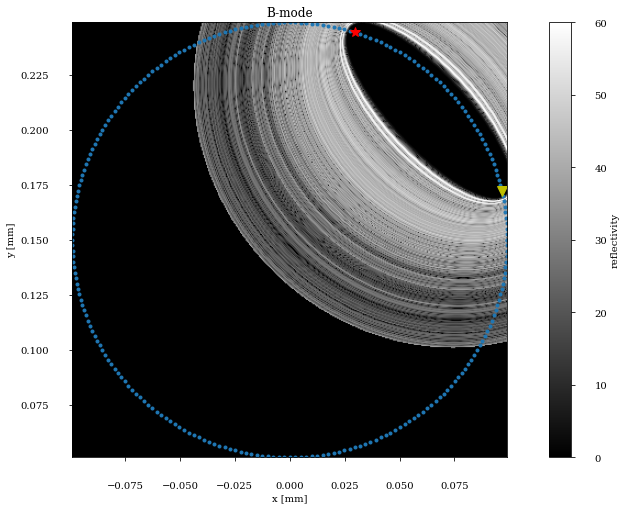

In [14]:
# Plot for one source-receiver pair.
plot_Bmode_image_example(
    reflectivity,
    g,
    isrc,
    irec_reflection,
    srccoo,
    reccoo,
    int(activeChannels[irec_reflection, isrc]),
)

In [15]:
# Let's also do it for one entire reflection subarray

refl_tot = np.zeros_like(reflectivity)
for iirec_reflection in range(numRxChannels):
    refl_tot += get_Bmode_image_example(
        phantom_data,
        srccoo[isrc, :][None, :],
        reccoo[isrc, :, :][None, :, :],
        activeChannels[iirec_reflection, isrc][None, None],
        m_prior,
        g,
        npoints,
        origin,
        sampling_rate,
    )

We can also take a look at the image that is generated from one source and its corresponding reflection array.

In [16]:
# Plot for one source and the entire reflection array.
plot_Bmode_image_example(
    refl_tot, g, isrc, irec_reflection, srccoo, reccoo, activeChannels
)

/Users/inesulrich/opt/miniconda3/envs/usct/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Slowly, we see how the image is constructed by adding reflection information for every source-receiver pair. Now we are ready to view the entire reconsrtuction!

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


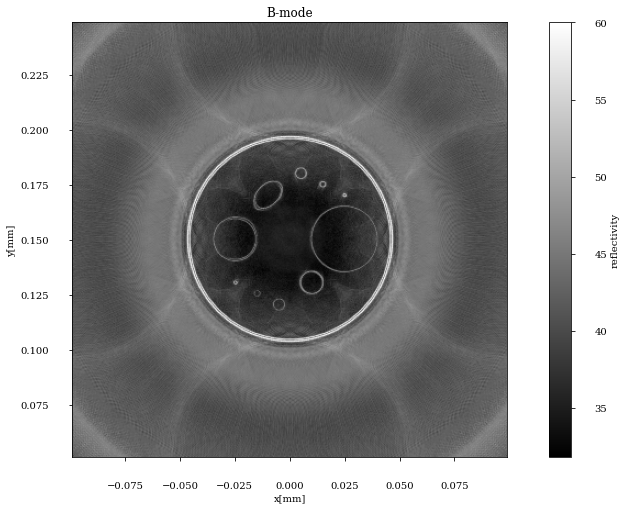

In [17]:
# For this data set, there is no acquisition delay, so we don't initialize it here.
reflectivity = get_Bmode_image(
    phantom_data,
    srccoo,
    reccoo,
    activeChannels,
    m_prior,
    g,
    npoints,
    origin,
    sampling_rate,
)
plot_Bmode_image(reflectivity, g)

That's it for this tutorial. I hope you learned something :-). I did...